# Estimating Turnover in Retail Trade

### Capstone Project by Christian Furger 

## Machine Learning - Clustering

In this notebook, a kMeans model is tuned. This is an unsupervised algorithm, which means that it doesn't use the target variable. To find the optimal number of clusters, the EllbowVizualizer from yellowbrick (https://pypi.org/project/yellowbrick/) is used. Once the clusters have been found, the mean turnover of each cluster is calculated. These cluster means are then used to estimate (impute) turnover of the enterprises in the test set falling into the respective clusters. As a baseline to evaluate the model, turnover one year before is used.
The model is tuned once with a dataset ending 2019 (before the coronavirus pandemic) and once with data up until 2020. At the end of this notebook, a quick comparison of the kMeans models and the baseline is done. In a final notebook (3.6), the different models are compared with each other.

In [1]:
# Import statements
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Preparation <a name="1"></a>

### 1.1 Import Data <a name="1.1"></a>

In [2]:
# Import datasets to compare the predictions
df2020_pred = pd.read_csv('df2020_pred.csv', index_col = ('OID', 'Date'), dtype = {'Stratum_Noga' : object, 'Noga_Enterprise' : object, 'Hist_Limit' : object})
df2019_pred = pd.read_csv('df2019_pred.csv', index_col = ('OID', 'Date'), dtype = {'Stratum_Noga' : object, 'Noga_Enterprise' : object, 'Hist_Limit' : object})

print('df2020_pred:', df2020_pred.shape)
print('df2019_pred:', df2019_pred.shape)

df2020_pred: (43180, 27)
df2019_pred: (37858, 27)


In [3]:
# Load the npz files 2020
with np.load('train_data_2020.npz', allow_pickle=False) as train_2020:
    train_data_2020 = dict(train_2020.items())
with np.load('train_data_rescaled_2020.npz', allow_pickle=False) as train_rescaled_2020:
    train_data_rescaled_2020 = dict(train_rescaled_2020.items())
with np.load('test_data_2020.npz', allow_pickle=False) as test_2020:
    test_data_2020 = dict(test_2020.items())
with np.load('test_data_rescaled_2020.npz', allow_pickle=False) as test_rescaled_2020:
    test_data_rescaled_2020 = dict(test_rescaled_2020.items())
    
# Create X/y arrays
X2020_tr = train_data_2020['features']
X2020_tr_rescaled = train_data_rescaled_2020['features']
y2020_tr = train_data_2020['targets']

X2020_te = test_data_2020['features']
X2020_te_rescaled = test_data_rescaled_2020['features']
y2020_te = test_data_2020['targets']

print('X2020_tr:', X2020_tr.shape)
print('X2020_tr_rescaled:', X2020_tr_rescaled.shape)
print('y2020_tr:', y2020_tr.shape)

print('X2020_te:', X2020_te.shape)
print('X2020_te_rescaled:', X2020_te_rescaled.shape)
print('y2020_te:', y2020_te.shape)

X2020_tr: (100753, 167)
X2020_tr_rescaled: (100753, 167)
y2020_tr: (100753,)
X2020_te: (43180, 167)
X2020_te_rescaled: (43180, 167)
y2020_te: (43180,)


In [4]:
# Load the npz files 2019
with np.load('train_data_2019.npz', allow_pickle=False) as train_2019:
    train_data_2019 = dict(train_2019.items())
with np.load('train_data_rescaled_2019.npz', allow_pickle=False) as train_rescaled_2019:
    train_data_rescaled_2019 = dict(train_rescaled_2019.items())
with np.load('test_data_2019.npz', allow_pickle=False) as test_2019:
    test_data_2019 = dict(test_2019.items())
with np.load('test_data_rescaled_2019.npz', allow_pickle=False) as test_rescaled_2019:
    test_data_rescaled_2019 = dict(test_rescaled_2019.items())
    
# Create X/y arrays
X2019_tr = train_data_2019['features']
X2019_tr_rescaled = train_data_rescaled_2019['features']
y2019_tr = train_data_2019['targets']

X2019_te = test_data_2019['features']
X2019_te_rescaled = test_data_rescaled_2019['features']
y2019_te = test_data_2019['targets']

print('X2019_tr:', X2019_tr.shape)
print('X2019_tr_rescaled:', X2019_tr_rescaled.shape)
print('y2019_tr:', y2019_tr.shape)

print('X2019_te:', X2019_te.shape)
print('X2019_te_rescaled:', X2019_te_rescaled.shape)
print('y2019_te:', y2019_te.shape)

X2019_tr: (88334, 165)
X2019_tr_rescaled: (88334, 165)
y2019_tr: (88334,)
X2019_te: (37858, 165)
X2019_te_rescaled: (37858, 165)
y2019_te: (37858,)


### 1.2 Create Baseline <a name="1.2"></a>

In [5]:
# Compare models with mean absolute error (MAE), mean squared error (MSE) and root mean squared error (RMSE)
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

def RMSE(y, y_pred):
    return np.sqrt(np.mean(np.square(y-y_pred)))

In [6]:
# Baseline 2020: turnover one year before
# Load the npz files
with np.load('y2020_te_baseline.npz', allow_pickle=False) as baseline_2020:
    y2020_baseline = dict(baseline_2020.items())

y2020_te_baseline = y2020_baseline['targets']    

mae_baseline2020 = MAE(np.expm1(y2020_te), np.expm1(y2020_te_baseline))
rmse_baseline2020=RMSE(np.expm1(y2020_te), np.expm1(y2020_te_baseline))
mse_baseline2020 = MSE(y2020_te, y2020_te_baseline)

print('Baseline (2020) MAE (in CHF): {:.2f}'.format(mae_baseline2020))
print('Baseline (2020) RMSE: {:.3f}'.format(rmse_baseline2020))
print('Baseline (2020) MSE: {:.3f}'.format(mse_baseline2020))

Baseline (2020) MAE (in CHF): 3145.04
Baseline (2020) RMSE: 40103.069
Baseline (2020) MSE: 15.322


In [7]:
# Baseline 2019: turnover one year before
# Load the npz files
with np.load('y2019_te_baseline.npz', allow_pickle=False) as baseline_2019:
    y2019_baseline = dict(baseline_2019.items())

y2019_te_baseline = y2019_baseline['targets']    

mae_baseline2019 = MAE(np.expm1(y2019_te), np.expm1(y2019_te_baseline))
rmse_baseline2019=RMSE(np.expm1(y2019_te), np.expm1(y2019_te_baseline))
mse_baseline2019 = MSE(y2019_te, y2019_te_baseline)

print('Baseline (2019) MAE (in CHF): {:.2f}'.format(mae_baseline2019))
print('Baseline (2019) RMSE: {:.3f}'.format(rmse_baseline2019))
print('Baseline (2019) MSE: {:.3f}'.format(mse_baseline2019))

Baseline (2019) MAE (in CHF): 2956.58
Baseline (2019) RMSE: 38434.627
Baseline (2019) MSE: 15.130


In [8]:
# Function to plot predicted vs real values
def plot_prediction(model,df,year,title):

    size=['small','medium','large']
    colors = ['red', 'green', 'blue']

    fig, axes = plt.subplots(1,len(size),figsize=(5*len(size),5))
    fig.suptitle(title+' ('+str(year)+'): Scatter plots of real vs predicted turnover (log)',fontsize=20)

    for i in range(0,3):
        size_df=df[df['Stratum_Size']==i+1]
        axes[i].scatter(np.log1p(size_df['TOV']), np.log1p(size_df['TOV_'+model]), label='', color=colors[i], s=1)
        axes[i].plot([0,14],[0,14], color='black', linewidth=1)

        #obtain a (slope) and b(intercept) of linear regression line
        a, b = np.polyfit(np.log1p(size_df['TOV']), np.log1p(size_df['TOV_'+model]), 1)
        
        # Generate a hundred values between 0 and 14
        x_values = np.linspace(0, 14, num=100)
        # Compute the associate y values
        y_values = a*x_values + b
        
        #add linear regression line to scatterplot          
        axes[i].plot(x_values, y_values, color=colors[i], label='slope: {:.2f}'.format(a))
           
        axes[i].set_title(size[i])
        axes[i].set_xlabel('real')
        axes[i].set_ylabel('predicted')
        axes[i].legend()

    plt.show()

## 2. Model fitting <a name="2"></a>

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import time

### 2.1 Dataset ending 2020<a name="2.1"></a>

Let's find the optimal number of clusters using the ElbowVisualizer.

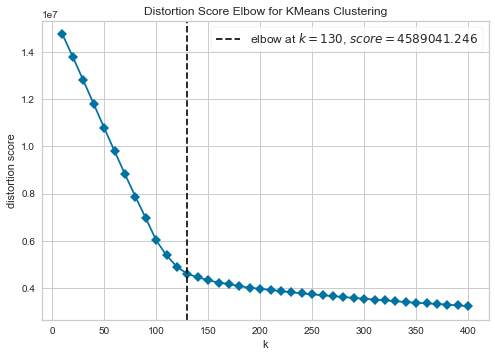

--- 5671.40s seconds ---


In [10]:
from yellowbrick.cluster import KElbowVisualizer

# Define X
X=X2020_tr_rescaled

# Define list of ks
k_list=[int(x) for x in np.linspace(start = 10, stop = 400, num = 40)]

start_time = time.time()

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(k_list), metric='distortion', timings=False)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure
print("--- %.2fs seconds ---" % (time.time() - start_time))

The optimal number of clusters is 130. Let's fit the kMeans estimator on the test set, predict the cluster of each entry and calculate mean turnover per cluster.

In [11]:
# Create and fit optimal k-Means clustering
kmeans_2020 = KMeans(
        n_clusters = 130,
        random_state= 42
    )

kmeans_2020.fit(X2020_tr_rescaled, None)

# Predict Cluster and calculate mean turnover
cl_2020= kmeans_2020.predict(X2020_tr_rescaled)
clus_2020=pd.DataFrame(cl_2020, columns=['cluster'])
clus_2020['TOV_log_cl']=y2020_tr.tolist()
clus_2020_mean=clus_2020.groupby('cluster').mean()
clus_2020_mean.head(10)

,TOV_log_cl
cluster,
0,6.581102
1,5.672910
2,6.035182
3,4.195931
4,3.643550
5,4.615672
6,5.849525
7,4.401466
8,4.895192


Predict the cluster of each entry in the test set, add the mean turnover from the train set and calculate the model accuracy.

In [12]:
# Predict Cluster for test set and add calculated mean turnover
cl_pred_kmeans2020 = kmeans_2020.predict(X2020_te_rescaled) # Predictions for test data

# Add cluster means
df_cl2020=pd.DataFrame(cl_pred_kmeans2020, columns=['cluster'])
df_cl2020.reset_index(inplace=True)
df_cl2020=pd.merge(df_cl2020, clus_2020_mean, on=['cluster'])

# Calculate predictions
df_cl2020['TOV_cl'] = np.expm1(df_cl2020.TOV_log_cl)
df_cl2020.sort_values('index', inplace=True)
df_cl2020.set_index('index', inplace=True)

y_pred_cl2020=df_cl2020['TOV_log_cl']

# Calculate model accuracy
mae_cl2020 = MAE(np.expm1(y2020_te), np.expm1(y_pred_cl2020))
rmse_cl2020=RMSE(np.expm1(y2020_te), np.expm1(y_pred_cl2020))
mse_cl2020 = MSE(y2020_te, y_pred_cl2020)

# Export model accuracy
cl2020=pd.DataFrame([['kMeans', '{:.3f}'.format(mae_cl2020), '{:.3f}'.format(rmse_cl2020), '{:.3f}'.format(mse_cl2020)]],
                 columns=['Model', 'MAE', 'RMSE', 'MSE'])
cl2020.to_csv("cl2020.csv", encoding='utf-8', index=False)
cl2020.head()

,Model,MAE,RMSE,MSE
0,kMeans,2758.461,37468.638,1.965


In [13]:
# Add prediction to dataset
df2020_pred['TOV_cl'] = np.expm1(y_pred_cl2020).tolist()

### 2.2 Dataset ending 2019<a name="2.2"></a>

Let's find the optimal number of clusters using the ElbowVisualizer.

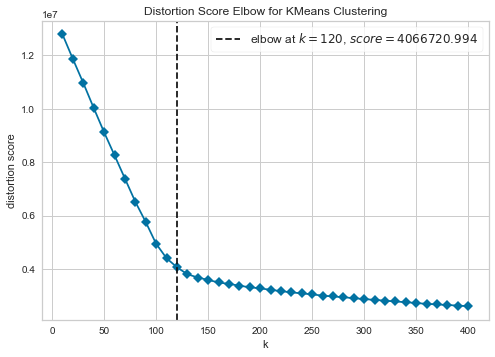

--- 5126.46s seconds ---


In [14]:
from yellowbrick.cluster import KElbowVisualizer

# Define X
X=X2019_tr_rescaled

# Define list of ks
k_list=[int(x) for x in np.linspace(start = 10, stop = 400, num = 40)]

start_time = time.time()

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(k_list), metric='distortion', timings=False)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure
print("--- %.2fs seconds ---" % (time.time() - start_time))

The optimal number of clusters is 120. Let's fit the kMeans estimator on the test set, predict the cluster of each entry and calculate mean turnover per cluster.

In [15]:
# Create and fit optimal k-Means clustering
kmeans_2019 = KMeans(
        n_clusters = 120,
        random_state= 42
    )

kmeans_2019.fit(X2019_tr_rescaled, None)

# Predict Cluster and calculate mean turnover
cl_2019= kmeans_2019.predict(X2019_tr_rescaled)
clus_2019=pd.DataFrame(cl_2019, columns=['cluster'])
clus_2019['TOV_log_cl']=y2019_tr.tolist()
clus_2019_mean=clus_2019.groupby('cluster').mean()
clus_2019_mean.head(10)

,TOV_log_cl
cluster,
0,5.305854
1,4.129922
2,5.453329
3,5.548660
4,5.172627
5,5.888811
6,4.249167
7,6.548536
8,8.424223


Predict the cluster of each entry in the test set, add the mean turnover from the train set and calculate the model accuracy.

In [16]:
# Predict Cluster for test set and add calculated mean turnover
cl_pred_kmeans2019 = kmeans_2019.predict(X2019_te_rescaled) # Predictions for test data

# Add cluster means
df_cl2019=pd.DataFrame(cl_pred_kmeans2019, columns=['cluster'])
df_cl2019.reset_index(inplace=True)
df_cl2019=pd.merge(df_cl2019, clus_2019_mean, on=['cluster'])

# Calculate predictions
df_cl2019['TOV_cl'] = np.expm1(df_cl2019.TOV_log_cl)
df_cl2019.sort_values('index', inplace=True)
df_cl2019.set_index('index', inplace=True)

y_pred_cl2019=df_cl2019['TOV_log_cl']

# Calculate model accuracy
mae_cl2019 = MAE(np.expm1(y2019_te), np.expm1(y_pred_cl2019))
rmse_cl2019=RMSE(np.expm1(y2019_te), np.expm1(y_pred_cl2019))
mse_cl2019 = MSE(y2019_te, y_pred_cl2019)

# Export model accuracy
cl2019=pd.DataFrame([['kMeans', '{:.3f}'.format(mae_cl2019), '{:.3f}'.format(rmse_cl2019), '{:.3f}'.format(mse_cl2019)]],
                 columns=['Model', 'MAE', 'RMSE', 'MSE'])
cl2019.to_csv("cl2019.csv", encoding='utf-8', index=False)
cl2019.head()

,Model,MAE,RMSE,MSE
0,kMeans,2628.059,36623.110,1.896


In [17]:
# Add prediction to dataset
df2019_pred['TOV_cl'] = np.expm1(y_pred_cl2019).tolist()

### 2.3 Model comparison<a name="2.3"></a>

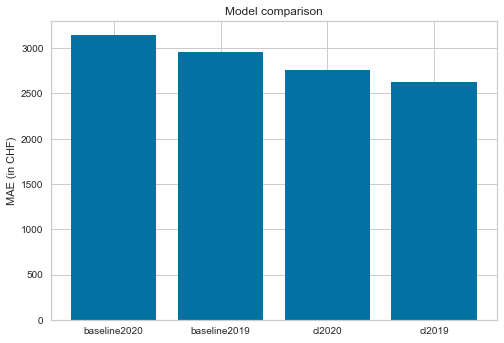

In [18]:
# Comparison
mae_values = [mae_baseline2020, mae_baseline2019, mae_cl2020, mae_cl2019]
titles = ['baseline2020', 'baseline2019', 'cl2020', 'cl2019']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)
plt.title('Model comparison')
plt.ylabel('MAE (in CHF)')
plt.show()

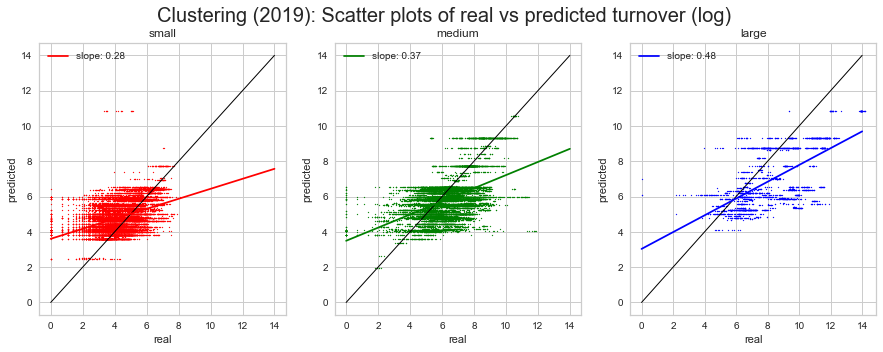

In [19]:
plot_prediction('cl',df2019_pred,2019,'Clustering')

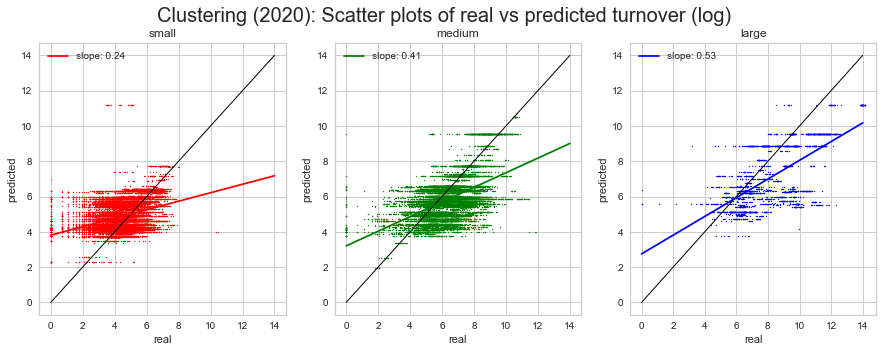

In [20]:
plot_prediction('cl',df2020_pred,2020,'Clustering')

In [21]:
# Exporting datasets with predictions
df2020_pred.to_csv("df2020_pred.csv", encoding='utf-8', index=True)
df2019_pred.to_csv("df2019_pred.csv", encoding='utf-8', index=True)

The kMeans estimater doesn't give good results, neither for the dataset ending 2019 nor for the complete dataset. Clustering is an unsupervised algorithm and therefore doesn't use the y variable. This algorithm doesn't use the whole information available for the task of estimating turnover, as we have information about turnover in the train set.